In [46]:
class linear_regression:
    def __init__(self, eta = 0.9, max_iter = 1e4, min_weight_dist = 1e-8):
        self.eta = eta
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0
        return np.sum((y - y_real)**2) / y_real.shape[0]
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        delta=(X.dot(self.w.T)+self.w0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0], np.sum(2*delta)/y_real.shape[0]
    def _optimize(self, X, Y):
        #оптимизация коэффициентов
        iter_num = 0
        weight_dist = np.inf
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
            gr_w, gr_w0=self._mserror_grad(X, Y)
            if iter_num==0:
                #Чтобы eta адаптировалась к порядку градиента, делим на l2 норму градиента в нуле
                eta=self.eta/np.sqrt(np.linalg.norm(gr_w)**2+(gr_w0)**2)
            new_w = self.w - eta * gr_w
            new_w0= self.w0 - eta * gr_w0
            weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)
            iter_num += 1
            self.w = new_w
            self.w0 = new_w0
    def fit(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        self._optimize(X, Y)
    def predict(self, X):
        return (X.dot(self.w.T)+self.w0).flatten()
    def test(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        return self._mserror(X, Y)

In [47]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [48]:
def log_loss_and_grad(w, X, target):
    m = X.shape[0]
    y=(2*target-1)
    score=np.dot(X, w.T).flatten()
    
    # Рассчёт log_loss
    loss = np.sum(np.log(1+np.exp(-y*score)))/m 
    
    # Рассчёт градиента
    Z=-y/(m*(1+np.exp(y*score)))
    grad=Z[np.newaxis, :].dot(X)
    return loss, grad


def optimize(w, X, y, n_iterations, eta):
    #     потери будем записывать в список для отображения в виде графика
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss_and_grad(w, X, y)
        w = w - eta * grad
        losses.append(loss)
        
    return w, losses

def predict(w, X):
    y_predicted = np.zeros(X.shape[0])  
    score=np.dot(X, w.T).flatten()
    Prob = 1/(1+np.exp(-score))
    
    #     За порог отнесения к тому или иному классу примем вероятность 0.5
    y_predicted[Prob>0.5]=1
    y_predicted[Prob<=0.5]=0
        
    return y_predicted

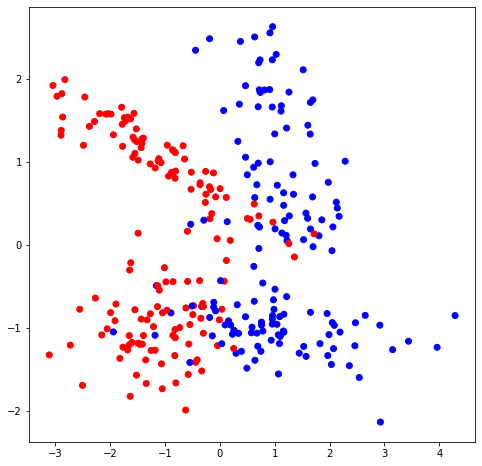

In [49]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=300, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [50]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (210, 2)
Размер массива признаков тестовой выборки (90, 2)
Размер массива ответов для обучающей выборки (210,)
Размер массива ответов для тестовой выборки (90,)


In [51]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    def _log_grad(self, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, self.w.T).flatten()+self.w0
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    def _optimize(self, X, y):
        for i in range(self.n_iterations):        
            grad_w, grad_w0 = self._log_grad(X, y)
            self.w = self.w-self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0
    def fit(self, X, y):
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        self._optimize(X, y)
    def predict_proba(self, X):  
        '''
        Рассчёт вероятности
        '''
        score=X.dot(self.w.T).flatten()+self.w0
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

In [52]:
mod=logistic_regression()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.11669558 0.00180821]]
Точность на обучающей выборке: 89.524
Точность на тестовой выборке: 88.889


In [53]:
np.unique(mod.predict_proba(X_test))

array([0.41658028, 0.41729747, 0.41892572, 0.42537416, 0.42913404,
       0.44283829, 0.44836545, 0.45028266, 0.45110526, 0.45257766,
       0.45425295, 0.45472566, 0.45597688, 0.45621656, 0.45681612,
       0.45798496, 0.45971349, 0.46236127, 0.46640733, 0.46724826,
       0.46770523, 0.46799383, 0.47008886, 0.47079089, 0.47227369,
       0.47273358, 0.47479144, 0.4779019 , 0.48229134, 0.48246785,
       0.48328135, 0.4848455 , 0.48694628, 0.48949   , 0.49000678,
       0.49020338, 0.49055479, 0.49124891, 0.49250239, 0.49441402,
       0.49448993, 0.49512459, 0.49528464, 0.49598293, 0.49977731,
       0.50010291, 0.50036297, 0.50364528, 0.50640149, 0.50660895,
       0.50676286, 0.5145641 , 0.51838499, 0.51987166, 0.52041929,
       0.52049226, 0.52124068, 0.52129263, 0.52141342, 0.52187566,
       0.52195078, 0.52218201, 0.52651926, 0.52699627, 0.52717811,
       0.527897  , 0.53002754, 0.53041162, 0.53068613, 0.53277376,
       0.53284387, 0.53319745, 0.5348647 , 0.53563317, 0.53709

In [54]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [55]:
print("Для порога по вероятности 0.5 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test), y_test)}")
print("Для порога по вероятности 0.75 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test, 0.75), y_test)}")

Для порога по вероятности 0.5 на тестовой выборке имеем: {'TP': 41, 'FP': 4, 'FN': 6, 'TN': 39}
Для порога по вероятности 0.75 на тестовой выборке имеем: {'TP': 0, 'FP': 0, 'FN': 47, 'TN': 43}


In [56]:
cofusion_fixed=confusion(mod.predict(X_test), y_test)
sensitivity=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FN'])
specificity=cofusion_fixed['TN']/(cofusion_fixed['TN']+cofusion_fixed['FP'])
balanced_accuracy=(sensitivity+specificity)/2
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность {sensitivity},"+
      f"специфичность {specificity}, сбалансированную точность {balanced_accuracy}")

Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность 0.8723404255319149,специфичность 0.9069767441860465, сбалансированную точность 0.8896585848589806


In [57]:
precision=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FP'])
recall=sensitivity
f1_score=2*precision*recall/(precision+recall)
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: точность {precision},"+
      f"полноту {recall}, f1-скор {f1_score}")

Для порога по вероятности 0.5 на тестовой выборке имеем: точность 0.9111111111111111,полноту 0.8723404255319149, f1-скор 0.891304347826087


Text(0, 0.5, 'Плотность вероятности')

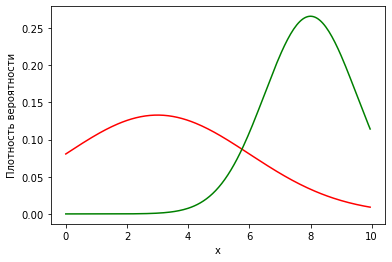

In [58]:
x=np.arange(0, 10, 0.05)
negative=norm.pdf(x, loc=3, scale=3)
positive=norm.pdf(x, loc=8, scale=1.5)
plt.plot(x, negative, color='r')
plt.plot(x, positive, color='g')
plt.xlabel('x')
plt.ylabel('Плотность вероятности')

In [59]:
probs = mod.predict_proba(X_test)

In [61]:
order = np.argsort(probs)
probs = probs[order]
y_test2 = y_test[:]

In [63]:
#Генерируем метки классов
target=y_test2
np.random.shuffle(target)

# К какому бы распределению не относился x мы значение кумулятовнойй функции распределения
#cdf(x) всегда случайное число с равномерным распределением в интервале от 0 до 1 
#Значит мы можем сгенерировать сначала значения кумулятивной функции, а затем по ним получить x
cdf_values=np.random.uniform(0, 1, size=(20,)) 
x=np.empty(cdf_values.shape)
x[target==1]=norm.ppf(cdf_values[target==1], loc=8, scale=1.5)
x[target==0]=norm.ppf(cdf_values[target==0], loc=3, scale=3)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 20 but corresponding boolean dimension is 90

In [64]:
target

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1])

In [65]:
order=np.argsort(x)
target=target[order]
x=x[order]

In [66]:
for _x, t in zip(x, target):
    print("Значение x:{0} класс {1}".format(_x, t))

Значение x:0.08622274966110899 класс 1
Значение x:0.12039949532268202 класс 0
Значение x:0.148573148891591 класс 1
Значение x:0.15596943503902738 класс 0
Значение x:0.2081612196246856 класс 0
Значение x:0.21163301255736744 класс 1
Значение x:0.2358187690175072 класс 0
Значение x:0.2873678416526434 класс 1
Значение x:0.29341799651052924 класс 0
Значение x:0.5431630702040212 класс 1
Значение x:0.6003849247602334 класс 0
Значение x:0.6708017260938597 класс 1
Значение x:0.6712339310097365 класс 1
Значение x:0.766072399141914 класс 1
Значение x:0.7995057337216088 класс 0
Значение x:0.8240099645738277 класс 0
Значение x:0.8603629493067113 класс 1
Значение x:0.9457283202399447 класс 0
Значение x:0.9837138578781456 класс 1
Значение x:0.9890772503799284 класс 0


In [67]:
bins_pos=target
bins_neg=1-target
num_pos, num_neg=np.sum(bins_pos), np.sum(bins_neg)
print(f'{num_pos} объектов положительного класса, {num_neg} объектов негативного класса')

10 объектов положительного класса, 10 объектов негативного класса


In [68]:
np.cumsum([1, 2, 3])

array([1, 3, 6], dtype=int32)

In [69]:
np.cumsum(bins_neg)

array([ 0,  1,  1,  2,  3,  3,  4,  4,  5,  5,  6,  6,  6,  6,  7,  8,  8,
        9,  9, 10], dtype=int32)

In [70]:
#Чувствительность, доля объектов негативного класса, которых при текущем значении предела
#правильно записали в негативный класс
TPR=np.concatenate([[0], np.cumsum(bins_neg)/num_neg])

#Ложно-позитивный уровень, доля объектов положительного класса, которых при текущем значении предела
#ошибочно записали в негативный класс
FPR=np.concatenate([[0], np.cumsum(bins_pos)/num_pos])

In [71]:
TPR

array([0. , 0. , 0.1, 0.1, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6,
       0.6, 0.6, 0.7, 0.8, 0.8, 0.9, 0.9, 1. ])

In [72]:
FPR

array([0. , 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6,
       0.7, 0.8, 0.8, 0.8, 0.9, 0.9, 1. , 1. ])

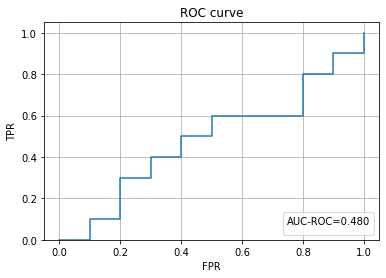

In [73]:
AUC_ROC = np.sum(0.5*(FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1]))

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

In [74]:
precision=np.cumsum(bins_neg)/(np.cumsum(bins_neg)+np.cumsum(bins_pos))
precision

array([0.        , 0.5       , 0.33333333, 0.5       , 0.6       ,
       0.5       , 0.57142857, 0.5       , 0.55555556, 0.5       ,
       0.54545455, 0.5       , 0.46153846, 0.42857143, 0.46666667,
       0.5       , 0.47058824, 0.5       , 0.47368421, 0.5       ])

In [75]:
recall = TPR
recall

array([0. , 0. , 0.1, 0.1, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6,
       0.6, 0.6, 0.7, 0.8, 0.8, 0.9, 0.9, 1. ])

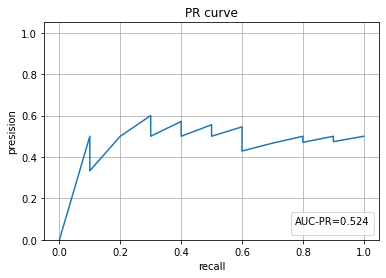

In [76]:
AUC_PR = np.sum(precision*(recall[1:]-recall[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall[1:], precision)